In [1]:
# imports
import pandas_datareader as pdr
import pandas as pd
import datetime as datetime
import matplotlib.pyplot as plt
import seaborn as sns
import quandl
import statsmodels.api as smapi
import statsmodels.tsa as tsa
import numpy as np
import scipy as sp
import pickle
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [353]:
class DATA():
    # economic data
    
    @classmethod
    def get_commod_data(cls,*args,**kwargs):
        data = {'oil': cls.get_oil_data, 'gasoline':cls.get_gasoline_data,
                'natgas': cls.get_natgas_data, 'corn':cls.get_corn_data,
                'wheat':cls.get_wheat_data}
        
        results = {x: data[x](*args,**kwargs) for x in data.keys()}
        return results
    
    #commodities data
    @staticmethod
    def get_oil(*args,**kwargs):
        data = quandl.get("CHRIS/CME_QM1")
        return data
    @staticmethod
    def get_gasoline(*args,**kwargs):
        data = quandl.get("CHRIS/ICE_N1")
        return data
    @staticmethod
    def get_natgas(*args, **kwargs):
        data = quandl.get("CHRIS/CME_NG2")
    @staticmethod
    def get_corn(*args, **kwargs):
        data = quandl.get("CHRIS/LIFFE_EMA2")
        return data
    @staticmethod
    def get_wheat(*args, **kwargs):
        data = quandl.get("CHRIS/CME_W4")
        return data
    # Economic data
    @staticmethod
    def get_mich_cons_sent(*args, **kwargs):
        data = quandl.get('UMICH/SOC1')
        return data['Index']
    @staticmethod
    def get_fred_gdp(*args,**kwargs):
        data = quandl.get("FRED/GDP")
        return data
    # interest rate data
    @staticmethod
    def get_us_yields(*args,**kwargs):
        data = quandl.get("USTREASURY/YIELD")
        return data
    
class STATS():
    @staticmethod
    def Demean(data,*args,**kwargs):
        dem_data = data.subtract(data.mean())
        return dem_data
    
    @staticmethod
    def two_sample_test(data,*args,**kwargs):
        # method to split data into two equal half samples and run some simple comparisons to check for stationarity
        # note: it's very likely we will not be able to fully prove it but if we can get reasonably close it will save
        # us alot of work
        ndim = len(data)
        data_fh = data[:int(ndim/2)]
        data_sh =data[int(ndim/2):]
        mean_fh = data_fh.mean()
        mean_sh = data_sh.mean()
        mean_fs =data.mean()
        var_fh = data_fh.var()
        var_sh = data_sh.var()
        var_fs = data.var()
        # getting the 
        
        results = {'mu_fh':mean_fh,'mu_sh':mean_sh,'mu_fs': mean_fs, 
                   'var_fh': var_fh, 'var_sh': var_sh, 'var_fs': var_fs}
        return pd.Series(results)
    
    @staticmethod
    def ADFuller(data,parse=True,*args,**kwargs):
        # method to run augmented dickey-fuller test for unit-root
        # if we can reject the null our series is probably weakly stationary
        # the default is that the series is to run with a constant (i.e. non-zero mean)
        # but we can demean the series first
        # we can put a max-lag after the fact
        # note that lag convention is pythonic i.e. lag=0 means an AR(1)
        
        def_args = {}
        def_args['maxlag']=kwargs.get('maxlag',None)
        def_args['regression']=kwargs.get('regression','c')
        if def_args['maxlag'] is None:
            def_args['autolag']=kwargs.get('autolag','t-stat')
        else:
            def_args['autolag']=None
        def_args['store']=kwargs.get('store',False)
        def_args['regresults']=kwargs.get('regresults',True)
        
        results = tsa.stattools.adfuller(data.values.reshape(-1,),**def_args)
        
        if parse:
            ad_results={'t-stat': results[0],'p-val':results[1],'ar_order':int(results[-1].usedlag+1)}
            ad_results.update(results[2])
            return pd.Series(ad_results)
        return results
    
    @staticmethod
    def compute_acf(data,*args,**kwargs):
        # return the sample autocorrelation function
        # by default return the confidence intervals
    
        def_args = {}
        def_args['unbiased']=kwargs.get('unbiased',False)
        def_args['nlags']=kwargs.get('nlags',36)
        def_args['qstat']=kwargs.get('qstat',False)
        def_args['alpha']=kwargs.get('alpha',0.05)
        
        results = tsa.stattools.acf(data,**def_args)
        return results
    
    @staticmethod
    def compute_pacf(data,*args,**kwargs):
        # return the sample autocorrelation function
        # by default return the confidence intervals
        def_args = {}
        def_args['nlags']=kwargs.get('nlags',36)
        def_args['method']=kwargs.get('method','ywunbiased')
        def_args['alpha']=kwargs.get('alpha',0.05)
        
        results = tsa.stattools.pacf(data,**def_args)
        return results
    
    @staticmethod
    def AR_model(data,holdout=None,*args,**kwargs):
        def_args = {}
        def_args['dates'] = kwargs.get('dates',None)
        def_args['freq'] = kwargs.get('freq',None)
        def_args['missing'] = kwargs.get('missing',None)
        models = {}
        armodel_fs = tsa.ar_model.AR(data,**def_args)
        models['fs'] = armodel_fs
        if holdout is not None:
            models['is'] = tsa.ar_model.AR(data[:-holdout],**def_args)
        
        return models
                
    @staticmethod
    def ARMA_model(data,holdout=None,maxp=3,maxq=3,*args,**kwargs):
        plags=range(maxp+1)
        qlags=range(maxq+1)
        p_q = [(x,y) for x in plags for y in qlags]
        models={}
        models['fs'] = {'arma({0},{1})'.format(x[0],x[1]):tsa.arima_model.ARMA(data,x,) for x in p_q}
        if holdout is not None:
            models['is'] = {'arma({0},{1})'.format(x[0],x[1]):tsa.arima_model.ARMA(data[:-holdout],x,) for x in p_q}
        return models
                
    @staticmethod
    def ARIMA_model(data,holdout=None,maxp=3,maxq=3,maxd=1,*args,**kwargs):
        plags=range(maxp+1)
        dlags=range(maxd+1)
        qlags=range(maxq+1)
        p_d_q = [(x,z,y) for x in plags for z in dlags for y in qlags]
        models={}
        models['fs'] = {'arima({0},{1},{2})'.format(x[0],x[1],x[2]):tsa.arima_model.ARIMA(endog=data,order=x,) for x in p_d_q}
        if holdout is not None:
            models['is'] = {'arima({0},{1},{2})'.format(x[0],x[1],x[2]):tsa.arima_model.ARIMA(endog=data[:-holdout],order=x,) 
                            for x in p_d_q}
        return models

        
        return all_models
        
    @staticmethod
    def SARIMA_model(data,holdout=None,maxp=3,maxq=3,maxd=1,maxP=0,maxD=0,maxQ=0,maxs=[0,],*args,**kwargs):
        plags=range(maxp+1)
        dlags=range(maxd+1)
        qlags=range(maxq+1)
        p_d_q = [(x,z,y) for x in plags for z in dlags for y in qlags]
        
        Plags=range(maxP+1)
        Dlags=range(maxD+1)
        Qlags=range(maxQ+1)
        slags=maxs
        P_D_Q_s = [(a,b,c,d) for a in Plags for b in Dlags for c in Qlags for d in slags]
        
        combs = [(x,y) for x in p_d_q for y in P_D_Q_s]
        sarima_ = tsa.statespace.sarimax.SARIMAX
        
        models={}
        fs_models = {}
        is_models = {}
        for s_combo in combs:
            try:
                fs_models['sarima({0}X{1})'.format(s_combo[0],s_combo[1])]=sarima_(endog=data,exog=None,order=s_combo[0],seasonal_order=s_combo[1],trend=None,)
                if holdout is not None:
                    is_models['sarima({0}X{1})'.format(s_combo[0],s_combo[1])]=sarima_(endog=data[:-holdout],exog=None,
                                                                                       order=s_combo[0],seasonal_order=s_combo[1],trend=None,)
            except:
                pass
        models['fs']=fs_models
        models['is']=is_models
        return models


##### Raw script

### Getting the data

In [219]:
# Getting the the data
data_cons = DATA.get_mich_cons_sent().truncate(before=datetime.datetime(1978,1,30))
ddata_cons = STATS.Demean(data_cons)
data_df = pd.DataFrame({'raw':data_cons,'dem': ddata_cons})

(-50, 150)

<Figure size 432x288 with 0 Axes>

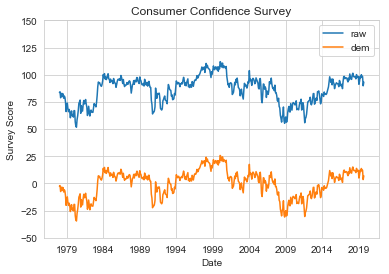

In [235]:
# plotting the data
fig_ = plt.figure()
sns.set_style('whitegrid')
data_df.plot()
ax_ = plt.gca()
ax_.set_title('Consumer Confidence Survey')
ax_.set_ylabel('Survey Score')
ax_.set_ylim(-50,150)


Notes: this is consumer sentiment data. The mean appears to be pretty stable and there are no obvious seasonal or trending patterns over the data

### Estimating and sample and partial ACFs

Text(0.5, 0, 'Lag')

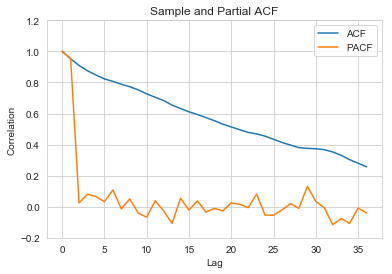

In [249]:
data_acf =STATS.compute_acf(ddata_cons)
data_pacf=STATS.compute_pacf(ddata_cons)
data_plot = pd.DataFrame({'ACF': data_acf[0], 'PACF': data_pacf[0]})
sns.set_style('whitegrid')
data_plot.plot()
ax_ = plt.gca()
ax_.set_title('Sample and Partial ACF')
ax_.set_ylabel('Correlation')
ax_.set_ylim(-0.2,1.2)
ax_.set_xlabel('Lag')

# plt.subplot(221)
# plt.plot(data_acf[0])
# plt.subplot(222)
# plt.plot(data_pacf[0])

Sample and partial autocorrelation functions plotted above. The sample autocorrelation suggests that there is persistence in the data but the PACF suggests that getting one lag incorporated reduces the other lags to near zero

### Stationarity test

In [217]:
simple_test = STATS.two_sample_test(data_cons)
# get up to two lags

adf_results = {}
adf_results['AR(1)'] = STATS.ADFuller(data_cons,maxlag=0)
adf_results['AR(2)'] = STATS.ADFuller(data_cons,maxlag=1)
adf_results['AR(3)'] = STATS.ADFuller(data_cons,maxlag=2)
adf_results['AR(4)'] = STATS.ADFuller(data_cons,maxlag=3)
adf_results['AR(5)'] = STATS.ADFuller(data_cons,maxlag=4)
adf_results['AR(6)'] = STATS.ADFuller(data_cons,maxlag=5)
adf_results['OPT_AIC'] = STATS.ADFuller(data_cons,autolag='aic')
adf_results['OPT_TST'] = STATS.ADFuller(data_cons,)

adf_results = pd.DataFrame(adf_results)



In [250]:
simple_test.to_excel('c:/Users/Ui-Wing/Downloads/simple_test.xlsx')

Notes: hard to tell much from this simple test. Probably will need to add some simple pair-mean / pair-variance tests but neither the means nor std. deviation look drastically different so this might suggest the data is near stationary - which is good!

In [149]:
adf_results

,AR(1),AR(2),AR(3),AR(4),AR(5),AR(6),OPT_AIC,OPT_TST
t-stat,-3.451318,-3.330288,-3.020307,-2.790945,-2.663056,-2.377887,-2.377887,-2.695491
p-val,0.009329,0.013578,0.033041,0.059579,0.080652,0.148075,0.148075,0.074822
ar_order,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,6.000000,13.000000
1%,-3.443496,-3.443523,-3.443549,-3.443576,-3.443603,-3.443630,-3.443630,-3.443821
5%,-2.867338,-2.867350,-2.867361,-2.867373,-2.867385,-2.867397,-2.867397,-2.867481
10%,-2.569858,-2.569864,-2.569870,-2.569877,-2.569883,-2.569889,-2.569889,-2.569934


In [150]:
# I'm going to dump the data here and put it in Excel to manually confirm the Dickey-Fuller test
data_df.to_excel('c:/Users/Ui-Wing/Downloads/cons_data.xlsx')
adf_results.to_excel('c:/Users/Ui-Wing/Downloads/adf_results.xlsx')

In [137]:
test_model = tsa.stattools.adfuller(data_cons,maxlag=0,regression='c',autolag=None,regresults=True)

In [142]:
test_model[-1].usedlag

Notes: this is decent result. A simple 2-lag (AR(3)) Augmented Dickey-Fuller test suggests that we can reject the null hypothesis that there is a unit root. A full test allowing the model to find the 'best-fit' suggests we cannot reject the null at even the 10% which is potentially a problem. The full test uses 5 lags which I think translates in python convention to an AR(6)
- so not definitive but it seems reasonable that the data is close but not exactly stationary

### Fitting an AR model

In [292]:
ar_model_opt = STATS.AR_model(ddata_cons,holdout=24)
# fit on the in-sample model
ar_fit = ar_model_opt['is'].fit(ic='aic',trend='nc',maxlag=None)
# we have to 'fit' inplace the fs model so we can use it for predictions
ar_fs = ar_model_opt['fs']
ar_fs.fit(ic='aic',trend='nc',maxlag=None)


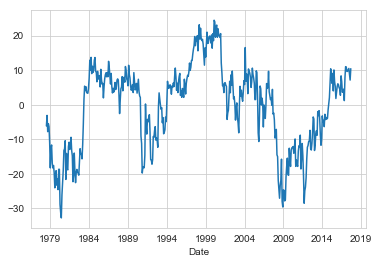

In [302]:
# Running some predictions
pred_is = ar_fit.fittedvalues.plot()
pred_os_hstep = ar_fit.predict(start=ddata_cons.index[-24],end=ddata_cons.index[-1])
# be ar_fs is an ar-model instance we can use the params from the insample fit
pred_os_1step = pd.Series(index=ddata_cons.index[-24:], 
                          data=ar_fs.predict(ar_fit.params,start=ddata_cons.index[-24],end=ddata_cons.index[-1]))


In [308]:
# get the parameters for the table
ar_fit.params.to_excel('c:/Users/Ui-Wing/Downloads/AR_fit.xlsx')

Text(0, 0.5, 'Demeaned Consumer Confidence')

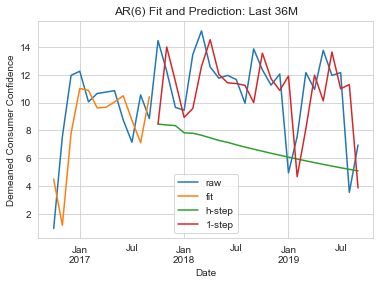

In [311]:
ar_pred_plot = pd.DataFrame({'raw':ddata_cons,'fit':ar_fit.fittedvalues,'h-step':pred_os_hstep,'1-step':pred_os_1step})
sns.set_style('whitegrid')
ar_pred_plot[-36:].plot()
ax_ = plt.gca()
ax_.set_title('AR(6) Fit and Prediction: Last 36M')
ax_.set_ylabel('Demeaned Consumer Confidence')

Text(0, 0.5, 'Demeaned Consumer Confidence')

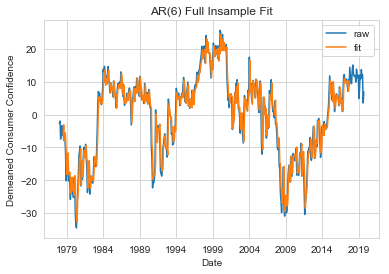

In [313]:
sns.set_style('whitegrid')
ar_pred_plot.loc[:,('raw','fit')].plot()
ax_ = plt.gca()
ax_.set_title('AR(6) Full Insample Fit')
ax_.set_ylabel('Demeaned Consumer Confidence')

###### An AR model seems to fit pretty well. The optimal fit found by minimizing the AIC appears to choose up to 6 lags. But even 1 lag seems to get pretty close.

### Fitting ARMA model

In [317]:
# this gets all the arma models
# we then have to fit each one and get the AIC
all_arma = STATS.ARMA_model(ddata_cons,holdout=24,maxp=10,maxq=10)

arma_fits = {}
for model in all_arma['is']:
    try:
        m_fit = all_arma['is'][model].fit(trend='nc')
        arma_fits[model]=m_fit
    except:
        print('failed on:{0}'.format(model))
        pass
        

failed on:arma(0,0)
failed on:arma(0,3)
failed on:arma(0,5)
failed on:arma(0,8)
failed on:arma(0,9)
failed on:arma(0,10)
failed on:arma(3,2)
failed on:arma(7,3)


In [318]:
arma_aic= pd.Series({x: arma_fits[x].aic for x in arma_fits})
print(arma_aic)

arma(0,1)      3319.614991
arma(0,2)      3050.154643
arma(0,4)      2847.636116
arma(0,6)      2773.138469
arma(0,7)      2753.528454
arma(1,0)      2649.101917
arma(1,1)      2651.028675
arma(1,2)      2648.825080
arma(1,3)      2648.292051
arma(1,4)      2650.180884
arma(1,5)      2648.614615
arma(1,6)      2649.533113
arma(1,7)      2651.527942
arma(1,8)      2652.363001
arma(1,9)      2651.959763
arma(1,10)     2653.122962
arma(2,0)      2651.042320
arma(2,1)      2653.023886
arma(2,2)      2647.851961
arma(2,3)      2648.034518
arma(2,4)      2649.634561
arma(2,5)      2649.611043
arma(2,6)      2651.534270
arma(2,7)      2653.079691
arma(2,8)      2653.317861
arma(2,9)      2653.523072
arma(2,10)     2655.122932
arma(3,0)      2649.324036
arma(3,1)      2647.729322
arma(3,3)      2648.913533
                  ...     
arma(8,3)      2645.271986
arma(8,4)      2649.916911
arma(8,5)      2655.026062
arma(8,6)      2652.844178
arma(8,7)      2653.543076
arma(8,8)      2655.450098
a

In [324]:
arma_opt=arma_fits[arma_aic[arma_aic==arma_aic.min()].index[0]]

arma_fs =all_arma['fs']['arma({0},{1})'.format(arma_opt.k_ar,arma_opt.k_ma)]
arma_fs.fit(trend='nc')



In [325]:
arma_opt.params

ar.L1.Index    0.724181
ar.L2.Index    1.496127
ar.L3.Index   -1.463276
ar.L4.Index   -0.580385
ar.L5.Index    0.728662
ar.L6.Index   -0.036580
ar.L7.Index    0.089547
ma.L1.Index    0.227217
ma.L2.Index   -1.419588
ma.L3.Index    0.227448
ma.L4.Index    0.999868
dtype: float64

In [326]:
# Running some arma predictions
arma_pred_os_hstep = arma_opt.predict(start=ddata_cons.index[-24],end=ddata_cons.index[-1])
# # be ar_fs is an ar-model instance we can use the params from the insample fit
arma_pred_os_1step = pd.Series(index=ddata_cons.index[-24:], 
                               data=arma_fs.predict(arma_opt.params,start=ddata_cons.index[-24],end=ddata_cons.index[-1]))


Text(0, 0.5, 'Demeaned Consumer Confidence')

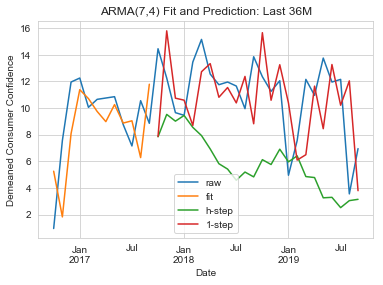

In [327]:
# plotting arma data
arma_pred_plot = pd.DataFrame({'raw':ddata_cons,'fit':arma_opt.fittedvalues,
                               'h-step':arma_pred_os_hstep,'1-step':arma_pred_os_1step})
sns.set_style('whitegrid')
arma_pred_plot[-36:].plot()
ax_ = plt.gca()
ax_.set_title('ARMA({0},{1}) Fit and Prediction: Last 36M'.format(arma_opt.k_ar,arma_opt.k_ma))
ax_.set_ylabel('Demeaned Consumer Confidence')

ARMA(7,4)


Text(0, 0.5, 'Demeaned Consumer Confidence')

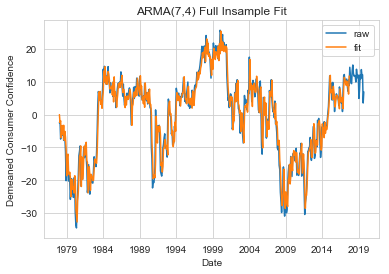

In [329]:
print('ARMA({0},{1})'.format(arma_opt.k_ar,arma_opt.k_ma))
sns.set_style('whitegrid')
arma_pred_plot.loc[:,('raw','fit')].plot()
ax_ = plt.gca()
ax_.set_title('ARMA({0},{1}) Full Insample Fit'.format(arma_opt.k_ar,arma_opt.k_ma))
ax_.set_ylabel('Demeaned Consumer Confidence')

Notes: An ARMA(5,4) seems to be the optimal fit but it's likely a pretty flat surface. 

### Fitting ARIMA model

In [331]:
# this gets all the arima models
# we then have to fit each one and get the AIC
all_arima = STATS.ARIMA_model(ddata_cons,holdout=24,maxp=10,maxq=10,maxd=2)
arima_fits = {}
for model in all_arima['is']:
    try:
        m_fit = all_arima['is'][model].fit(trend='nc')
        arima_fits[model]=m_fit
    except:
        print('failed on:{0}'.format(model))
        pass


failed on:arima(0,0,0)
failed on:arima(0,0,3)
failed on:arima(0,0,5)
failed on:arima(0,0,8)
failed on:arima(0,0,9)
failed on:arima(0,0,10)
failed on:arima(0,1,0)
failed on:arima(0,2,0)
failed on:arima(0,2,3)
failed on:arima(0,2,4)
failed on:arima(0,2,5)
failed on:arima(0,2,6)
failed on:arima(0,2,7)
failed on:arima(0,2,8)
failed on:arima(0,2,9)
failed on:arima(0,2,10)
failed on:arima(1,1,1)
failed on:arima(1,1,2)
failed on:arima(1,1,3)
failed on:arima(1,1,4)
failed on:arima(1,1,5)
failed on:arima(1,1,6)
failed on:arima(1,1,7)
failed on:arima(1,1,8)
failed on:arima(1,1,9)
failed on:arima(1,1,10)
failed on:arima(1,2,2)
failed on:arima(1,2,3)
failed on:arima(1,2,5)
failed on:arima(1,2,6)
failed on:arima(1,2,7)
failed on:arima(1,2,8)
failed on:arima(1,2,9)
failed on:arima(1,2,10)
failed on:arima(2,1,2)
failed on:arima(2,1,3)
failed on:arima(2,1,4)
failed on:arima(2,1,5)
failed on:arima(2,1,6)
failed on:arima(2,1,7)
failed on:arima(2,1,8)
failed on:arima(2,1,9)
failed on:arima(2,1,10)
failed

In [341]:
arima_aic= pd.Series({x: arima_fits[x].aic for x in arima_fits})
arima_opt= arima_fits[arima_aic[arima_aic==arima_aic.min()].index[0]]
print('ARIMA({0},{1},{2})'.format(arima_opt.k_ar,arima_opt.k_diff,arima_opt.k_ma,))

arima_fs =all_arima['fs']['arima({0},{1},{2})'.format(arima_opt.k_ar,arima_opt.k_diff,arima_opt.k_ma)]
arima_fs.fit(trend='nc')


ARIMA(6,1,5)


In [348]:
# Running some arma predictions
arima_pred_os_hstep = arima_opt.predict(start=ddata_cons.index[-24],end=ddata_cons.index[-1],typ='levels')
# # be ar_fs is an ar-model instance we can use the params from the insample fit
arima_pred_os_1step = pd.Series(index=ddata_cons.index[-24:], 
                               data=arima_fs.predict(arima_opt.params,start=ddata_cons.index[-24],
                                                     end=ddata_cons.index[-1],typ='levels'))


Text(0, 0.5, 'Demeaned Consumer Confidence')

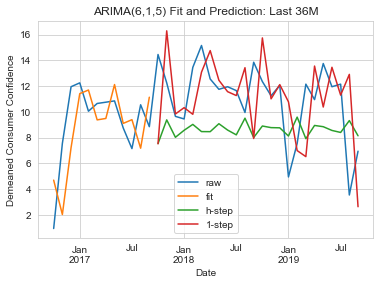

In [351]:
# plotting arima data
# for arima we have to use 'prediction values' in stead of fitted because something is not right with the fit
arima_pred_plot = pd.DataFrame({'raw':ddata_cons,'fit':arima_opt.predict(typ='levels'),
                               'h-step':arima_pred_os_hstep,'1-step':arima_pred_os_1step})
sns.set_style('whitegrid')
arima_pred_plot[-36:].plot()
ax_ = plt.gca()
ax_.set_title('ARIMA({0},{1},{2}) Fit and Prediction: Last 36M'.format(arima_opt.k_ar,arima_opt.k_diff,arima_opt.k_ma))
ax_.set_ylabel('Demeaned Consumer Confidence')

ARIMA(6,1,5)


Text(0, 0.5, 'Demeaned Consumer Confidence')

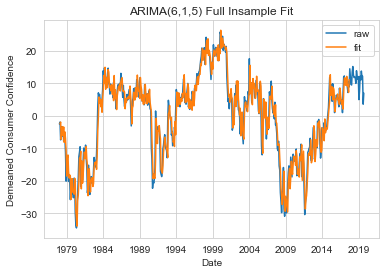

In [352]:
print('ARIMA({0},{1},{2})'.format(arima_opt.k_ar,arima_opt.k_diff,arima_opt.k_ma))
sns.set_style('whitegrid')
arima_pred_plot.loc[:,('raw','fit')].plot()
ax_ = plt.gca()
ax_.set_title('ARIMA({0},{1},{2}) Full Insample Fit'.format(arima_opt.k_ar,arima_opt.k_diff,arima_opt.k_ma))
ax_.set_ylabel('Demeaned Consumer Confidence')

### Fitting Sarima model

In [354]:
all_sarima = STATS.SARIMA_model(ddata_cons,holdout=24,maxp=3,maxq=3,maxd=2,maxP=3,maxD=1,maxQ=1,maxs=[3,6,9,12],)
sarima_fits = {}
for model in all_sarima['is']:
    try:
        m_fit = all_sarima['is'][model].fit()
        sarima_fits[model]=m_fit
    except:
        print('failed on:{0}'.format(model))
        pass

failed on:sarima((0, 2, 3)X(0, 0, 0, 3))
failed on:sarima((0, 2, 3)X(0, 0, 0, 6))
failed on:sarima((0, 2, 3)X(0, 0, 0, 9))
failed on:sarima((0, 2, 3)X(0, 0, 0, 12))
failed on:sarima((0, 2, 3)X(0, 0, 1, 3))
failed on:sarima((0, 2, 3)X(0, 0, 1, 6))
failed on:sarima((0, 2, 3)X(0, 0, 1, 9))
failed on:sarima((0, 2, 3)X(0, 0, 1, 12))
failed on:sarima((0, 2, 3)X(0, 1, 0, 3))
failed on:sarima((0, 2, 3)X(0, 1, 0, 12))
failed on:sarima((0, 2, 3)X(0, 1, 1, 3))
failed on:sarima((0, 2, 3)X(0, 1, 1, 12))
failed on:sarima((0, 2, 3)X(1, 0, 0, 3))
failed on:sarima((0, 2, 3)X(1, 0, 0, 6))
failed on:sarima((0, 2, 3)X(1, 0, 0, 9))
failed on:sarima((0, 2, 3)X(1, 0, 0, 12))
failed on:sarima((0, 2, 3)X(1, 0, 1, 3))
failed on:sarima((0, 2, 3)X(1, 0, 1, 6))
failed on:sarima((0, 2, 3)X(1, 0, 1, 9))
failed on:sarima((0, 2, 3)X(1, 0, 1, 12))
failed on:sarima((0, 2, 3)X(1, 1, 0, 3))
failed on:sarima((0, 2, 3)X(1, 1, 0, 12))
failed on:sarima((0, 2, 3)X(1, 1, 1, 3))
failed on:sarima((0, 2, 3)X(1, 1, 1, 12))
failed o

failed on:sarima((2, 1, 1)X(1, 1, 0, 9))
failed on:sarima((2, 1, 1)X(1, 1, 0, 12))
failed on:sarima((2, 1, 1)X(1, 1, 1, 3))
failed on:sarima((2, 1, 1)X(1, 1, 1, 9))
failed on:sarima((2, 1, 1)X(1, 1, 1, 12))
failed on:sarima((2, 1, 1)X(2, 1, 0, 3))
failed on:sarima((2, 1, 1)X(2, 1, 0, 9))
failed on:sarima((2, 1, 1)X(2, 1, 0, 12))
failed on:sarima((2, 1, 1)X(2, 1, 1, 3))
failed on:sarima((2, 1, 1)X(2, 1, 1, 9))
failed on:sarima((2, 1, 1)X(2, 1, 1, 12))
failed on:sarima((2, 1, 1)X(3, 1, 0, 3))
failed on:sarima((2, 1, 1)X(3, 1, 0, 9))
failed on:sarima((2, 1, 1)X(3, 1, 0, 12))
failed on:sarima((2, 1, 1)X(3, 1, 1, 3))
failed on:sarima((2, 1, 1)X(3, 1, 1, 9))
failed on:sarima((2, 1, 1)X(3, 1, 1, 12))
failed on:sarima((2, 1, 2)X(0, 1, 0, 6))
failed on:sarima((2, 1, 2)X(0, 1, 0, 12))
failed on:sarima((2, 1, 2)X(0, 1, 1, 6))
failed on:sarima((2, 1, 2)X(0, 1, 1, 12))
failed on:sarima((2, 1, 2)X(1, 1, 0, 6))
failed on:sarima((2, 1, 2)X(1, 1, 0, 12))
failed on:sarima((2, 1, 2)X(1, 1, 1, 6))
failed 

failed on:sarima((3, 0, 3)X(2, 1, 1, 6))
failed on:sarima((3, 0, 3)X(2, 1, 1, 9))
failed on:sarima((3, 0, 3)X(2, 1, 1, 12))
failed on:sarima((3, 0, 3)X(3, 0, 0, 3))
failed on:sarima((3, 0, 3)X(3, 0, 0, 6))
failed on:sarima((3, 0, 3)X(3, 0, 0, 9))
failed on:sarima((3, 0, 3)X(3, 0, 0, 12))
failed on:sarima((3, 0, 3)X(3, 0, 1, 3))
failed on:sarima((3, 0, 3)X(3, 0, 1, 6))
failed on:sarima((3, 0, 3)X(3, 0, 1, 9))
failed on:sarima((3, 0, 3)X(3, 0, 1, 12))
failed on:sarima((3, 0, 3)X(3, 1, 0, 6))
failed on:sarima((3, 0, 3)X(3, 1, 0, 9))
failed on:sarima((3, 0, 3)X(3, 1, 0, 12))
failed on:sarima((3, 0, 3)X(3, 1, 1, 6))
failed on:sarima((3, 0, 3)X(3, 1, 1, 9))
failed on:sarima((3, 0, 3)X(3, 1, 1, 12))
failed on:sarima((3, 1, 2)X(0, 1, 0, 6))
failed on:sarima((3, 1, 2)X(0, 1, 0, 9))
failed on:sarima((3, 1, 2)X(0, 1, 0, 12))
failed on:sarima((3, 1, 2)X(0, 1, 1, 6))
failed on:sarima((3, 1, 2)X(0, 1, 1, 9))
failed on:sarima((3, 1, 2)X(0, 1, 1, 12))
failed on:sarima((3, 1, 2)X(1, 1, 0, 6))
failed on

In [367]:
sarima_aic= pd.Series({x: sarima_fits[x].aic for x in sarima_fits})
sarima_opt= sarima_fits[sarima_aic[sarima_aic==sarima_aic.min()].index[0]]
# print(sarima_aic)
print(sarima_aic[sarima_aic==sarima_aic.min()].index[0])

sarima_fs =all_sarima['fs'][sarima_aic[sarima_aic==sarima_aic.min()].index[0]]
sarima_fs = sarima_fs.fit()



sarima((1, 1, 1)X(0, 1, 1, 12))


In [377]:
# Running some sarima predictions
sarima_pred_os_hstep = sarima_opt.predict(start=ddata_cons.index[-24],end=ddata_cons.index[-1],typ='levels')
# this sucks - the prediction function for sarima is not complete in statsmodels
# cheat here - use the insample fit from the full sample - basically this is now a rolling 1mth fit with the parameters
# but it doesn't look too different from the others so probably not too bad
sarima_pred_os_1step = sarima_fs.predict(start=ddata_cons.index[-24],
                                         end=ddata_cons.index[-1],typ='levels',dynamic=False)


Text(0, 0.5, 'Demeaned Consumer Confidence')

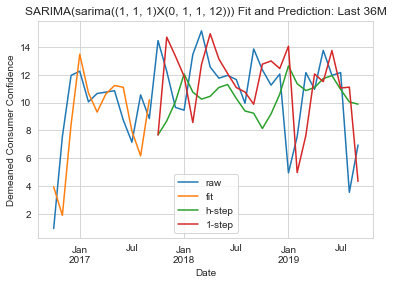

In [379]:
# plotting sarima data
# for sarima we have to use 'prediction values' in stead of fitted because something is not right with the fit
sarima_pred_plot = pd.DataFrame({'raw':ddata_cons,'fit':sarima_opt.predict(typ='levels'),
                                 'h-step':sarima_pred_os_hstep,'1-step':sarima_pred_os_1step})
sns.set_style('whitegrid')
sarima_pred_plot[-36:].plot()
ax_ = plt.gca()
ax_.set_title('SARIMA({0}) Fit and Prediction: Last 36M'.format(sarima_aic[sarima_aic==sarima_aic.min()].index[0]))
ax_.set_ylabel('Demeaned Consumer Confidence')

###  COMPARING THE FITS

Text(0, 0.5, 'Demeaned Consumer Confidence')

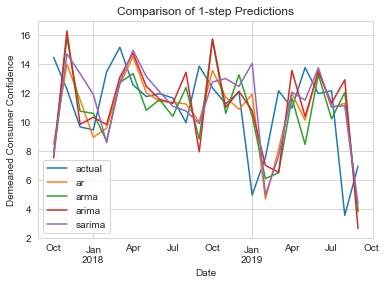

In [384]:
# comparing ar,arima,sarima
preds_1step_compare = pd.DataFrame({'actual': ddata_cons,'ar':pred_os_1step,'arma':arma_pred_os_1step,'arima':arima_pred_os_1step,
                                    'sarima': sarima_pred_os_1step}).dropna(how='any',axis=0)

sns.set_style('whitegrid')
preds_1step_compare.plot()
ax_ = plt.gca()
ax_.set_title('Comparison of 1-step Predictions')
ax_.set_ylabel('Demeaned Consumer Confidence')


Text(0, 0.5, 'Demeaned Consumer Confidence')

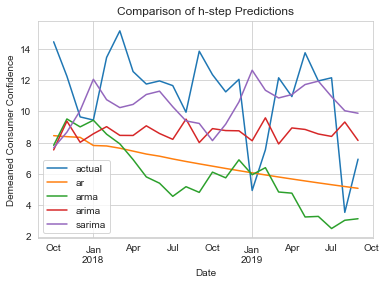

In [385]:
# comparing the h-step predictions
# comparing ar,arma, arima,sarima
preds_hstep_compare = pd.DataFrame({'actual': ddata_cons,'ar':pred_os_hstep,'arma':arma_pred_os_hstep,'arima':arima_pred_os_hstep,
                                    'sarima': sarima_pred_os_hstep}).dropna(how='any',axis=0)
sns.set_style('whitegrid')
preds_hstep_compare.plot()
ax_ = plt.gca()
ax_.set_title('Comparison of h-step Predictions')
ax_.set_ylabel('Demeaned Consumer Confidence')



### Comparing AIC

In [65]:
# summarizing fits

optimal_models = {'AR({0})'.format(ar_opt.k_ar):ar_opt.aic,
                 'ARMA({0},{1})'.format(arma_opt.k_ar,arma_opt.k_ma):arma_opt.aic,
                 'ARIMA({0},{1},{2})'}

In [66]:
optimal_models

{'AR(6)': 2.6992842609610754}

array([ -6.10801903,  -3.16460962,  -7.76770522,  -5.5240246 ,
        -6.34659118, -10.80824384, -18.199181  , -12.80350036,
       -11.62493554, -16.86515822, -18.34476866, -17.6209209 ,
       -19.63999344, -23.99274735, -20.26974998, -19.0974356 ,
       -23.23108792, -21.52325704, -24.56027381, -18.75025485,
       -18.70437413, -28.79124807, -31.14762231, -32.7060611 ,
       -26.06570185, -22.7126728 , -19.03549187, -13.40559595,
       -12.87900059, -10.53438272, -21.54504973, -14.21451374,
       -18.43626749, -18.81936866, -12.24454113, -10.90071057,
       -12.96795105, -11.95960742,  -9.49445164, -13.20323469,
       -14.81206172, -22.20457945, -20.38433343, -14.03739134,
       -19.12133351, -22.56220018, -19.8195869 , -18.71270969,
       -19.61406031, -19.77667474, -20.40842268, -16.65183545,
       -12.80228756, -14.32848254, -14.20842   , -15.69151906,
       -11.63306121,  -5.71043966,   1.4820835 ,   5.23495373,
         3.9910381 ,   5.09424118,   3.57001392,   3.33